<a href="https://colab.research.google.com/github/Hawar-Dzaee/UNet-from-scratch/blob/main/Unet_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch the data  

In [ ]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip

# Necessary Installation

In [ ]:
!pip install -q neptune neptune_pytorch torchviz

In [ ]:
# Pytorch
import torch
from torch import nn
from torch.optim import Adam,AdamW,SGD
from torchvision import transforms as T
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision.models import vgg16_bn, VGG16_BN_Weights


import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import cv2
import random
from itertools import chain
from glob import glob
from random import choice

# for model experiment
import neptune

# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [ ]:
run = neptune.init_run(
    project= "# YOUR WORKSPACE",
    api_token="YOUR API TOKEN",
)



In [ ]:
HyperParameters = {
    "epochs":30,
    "batch_size": 4,
    "optimization" : AdamW,
    "lr": 1e-3,
    "model_filename": "First_model",
    "device": device
}

# Understanding The Dataset

In [ ]:
fpath_train_input = glob('dataset1/images_prepped_train/*.png')       # directory for x_train a.k.a [input image]
fpath_train_output = glob('dataset1/annotations_prepped_train/*.png') # directory for y_train a.k.a [output image]

fpath_test_input = glob('dataset1/images_prepped_test/*.png')         # directory for x_test a.k.a [input image]
fpath_test_output = glob('dataset1/annotations_prepped_test/*.png')   # directory for y_test a.k.a [input image]

print(f'number of training samples : {len(fpath_train_input)}')
print(f'number of testing samples  : {len(fpath_test_input)}')

number of training samples : 367
number of testing samples  : 101


# Understanding a single sample

shape of the input Image  : (360, 480, 3)
shape of the output Image : (360, 480)


Text(0.5, 1.0, 'output_image')

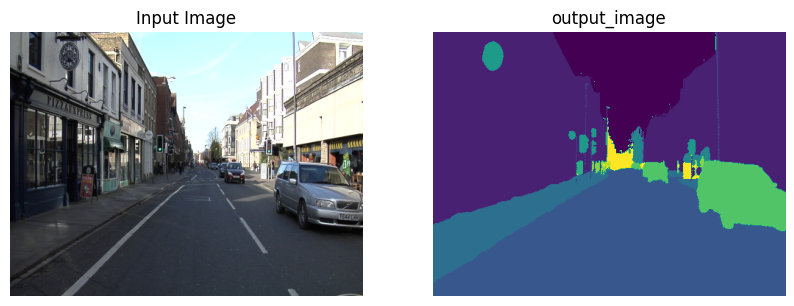

In [ ]:
random_index = choice(range(len(fpath_train_input)))        # generate a random number [we will use it to fetch a random image, and it's corresponding output image]

# Input Image
input_image_BGR= cv2.imread(fpath_train_input[random_index])    # read the image
input_image = cv2.cvtColor(input_image_BGR,cv2.COLOR_BGR2RGB)   # by default cv2 reads image in BGR we have to convert it to RGB.
print(f'shape of the input Image  : {input_image.shape}')

# output Image
output_image = cv2.imread(fpath_train_output[random_index],cv2.IMREAD_GRAYSCALE)
print(f'shape of the output Image : {output_image.shape}')

# Visualize Input & output Image
fig,ax = plt.subplots(1,2,figsize=(10,8))

ax[0].imshow(input_image)
ax[0].axis('off')
ax[0].set_title('Input Image')

ax[1].imshow(output_image)
ax[1].axis('off')
ax[1].set_title('output_image')

# Understanding output image

- The output_image is a single channel [refer to the output shape above].

- The values in the output_image range from [0, 11], representing 12 distinct classes.

# Task

We feed the input image to the model, and the model produces an output image, where each pixel is labeled with the correct class.

# Preparing the Dataset

In [ ]:
tfms = T.Compose([T.ToTensor(),
                  T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                  ])

In [ ]:
class SegData(Dataset):
  def __init__(self,split,transforms=tfms):
     self.X_dir = sorted(glob(f'dataset1/images_prepped_{split}/*.png'))
     self.y_dir = sorted(glob(f'dataset1/annotations_prepped_{split}/*.png'))
     self.transform = transforms

  def __len__(self):
    return len(self.X_dir)

  def __getitem__(self,ix):
     # input image
     x = cv2.imread(self.X_dir[ix])
     x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
     x = cv2.resize(x,(224,224))
     if self.transform:
      x = tfms(x)

     # output image
     y = cv2.imread(self.y_dir[ix],cv2.IMREAD_GRAYSCALE)
     y = cv2.resize(y,(224,224))
     y = torch.tensor(y,dtype=torch.long)
     return x,y

### Train_Test split

In [ ]:
train_ds = SegData('train')
test_ds  = SegData('test')

### Train_Val split

further splitting the trainset into train and validation dataset

In [ ]:
train_size = int(len(train_ds) * 0.8)
val_size = len(train_ds) - train_size

print(train_size)
print(val_size)

train_ds,val_ds = random_split(train_ds,lengths=[train_size,val_size])

293
74


### DataLoader


In [ ]:
train_dl = DataLoader(train_ds,batch_size = HyperParameters['batch_size'],shuffle=True)
val_dl   = DataLoader(val_ds,  batch_size = HyperParameters['batch_size'],shuffle=False)
test_dl  = DataLoader(test_ds, batch_size = HyperParameters['batch_size'],shuffle=False)

making sure we have the right shape of data

In [ ]:
for x,y in train_dl:
  print(x.shape)
  print(y.shape)
  break
print('--------------')
for x,y in val_dl:
  print(x.shape)
  print(y.shape)
  break
print('--------------')
for x,y in test_dl:
  print(x.shape)
  print(y.shape)
  break

torch.Size([4, 3, 224, 224])
torch.Size([4, 224, 224])
--------------
torch.Size([4, 3, 224, 224])
torch.Size([4, 224, 224])
--------------
torch.Size([4, 3, 224, 224])
torch.Size([4, 224, 224])


# Architecture

### blocks

we will be using `blocks` in `Main` section

In [ ]:
def conv(in_channels,out_channels):
  return nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
                       nn.BatchNorm2d(out_channels),
                       nn.ReLU(inplace=True)
                       )

def up_conv(in_channels,out_channels):
  return nn.Sequential(nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2),
                       nn.ReLU(inplace=True)
                       )

### Backbone

we will be using  pre-trained model`vgg16` as  `backbone` in the `Main` section.

In [ ]:
encoder = vgg16_bn(weights= VGG16_BN_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 79.4MB/s]


### Main

In [ ]:
class UNet(nn.Module):

  def __init__(self,pretrained=True,out_channels=12):
    super().__init__()

    # Encoder part, (using backbone)
    self.encoder = encoder.features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])
    self.bottleneck = nn.Sequential(*self.encoder[34:])

    self.conv_bottleneck = conv(512,1024)

    # Deconder part
    self.up_conv6 = up_conv(1024,512)
    self.conv6 = conv( 512+512 ,512)
    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256 + 512, 256)
    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128 + 256, 128)
    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64 + 128, 64)
    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32 + 64, 32)

    self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

  def forward(self,x):
    # image input is (1,3,224,224)
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    bottleneck = self.bottleneck(block5)

    x = self.conv_bottleneck(bottleneck)

    # so far nothing new, it's same as a borning vanilla CNN architecture.

    # new stuff
    x = self.up_conv6(x)
    x = torch.cat([x,block5],dim=1)   # concatenating across the channels
    x = self.conv6(x)

    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)

    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)

    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)

    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)
    x = self.conv10(x)

    x = self.conv11(x)

    return x

The diagram below reflects the architecture described above.

- The blocks in the diagram are labeled based on the code.

- The attributes in the diagram correspond to those in the code.

- The shape(i.e dimension) of each step mirrors the structure of the code."

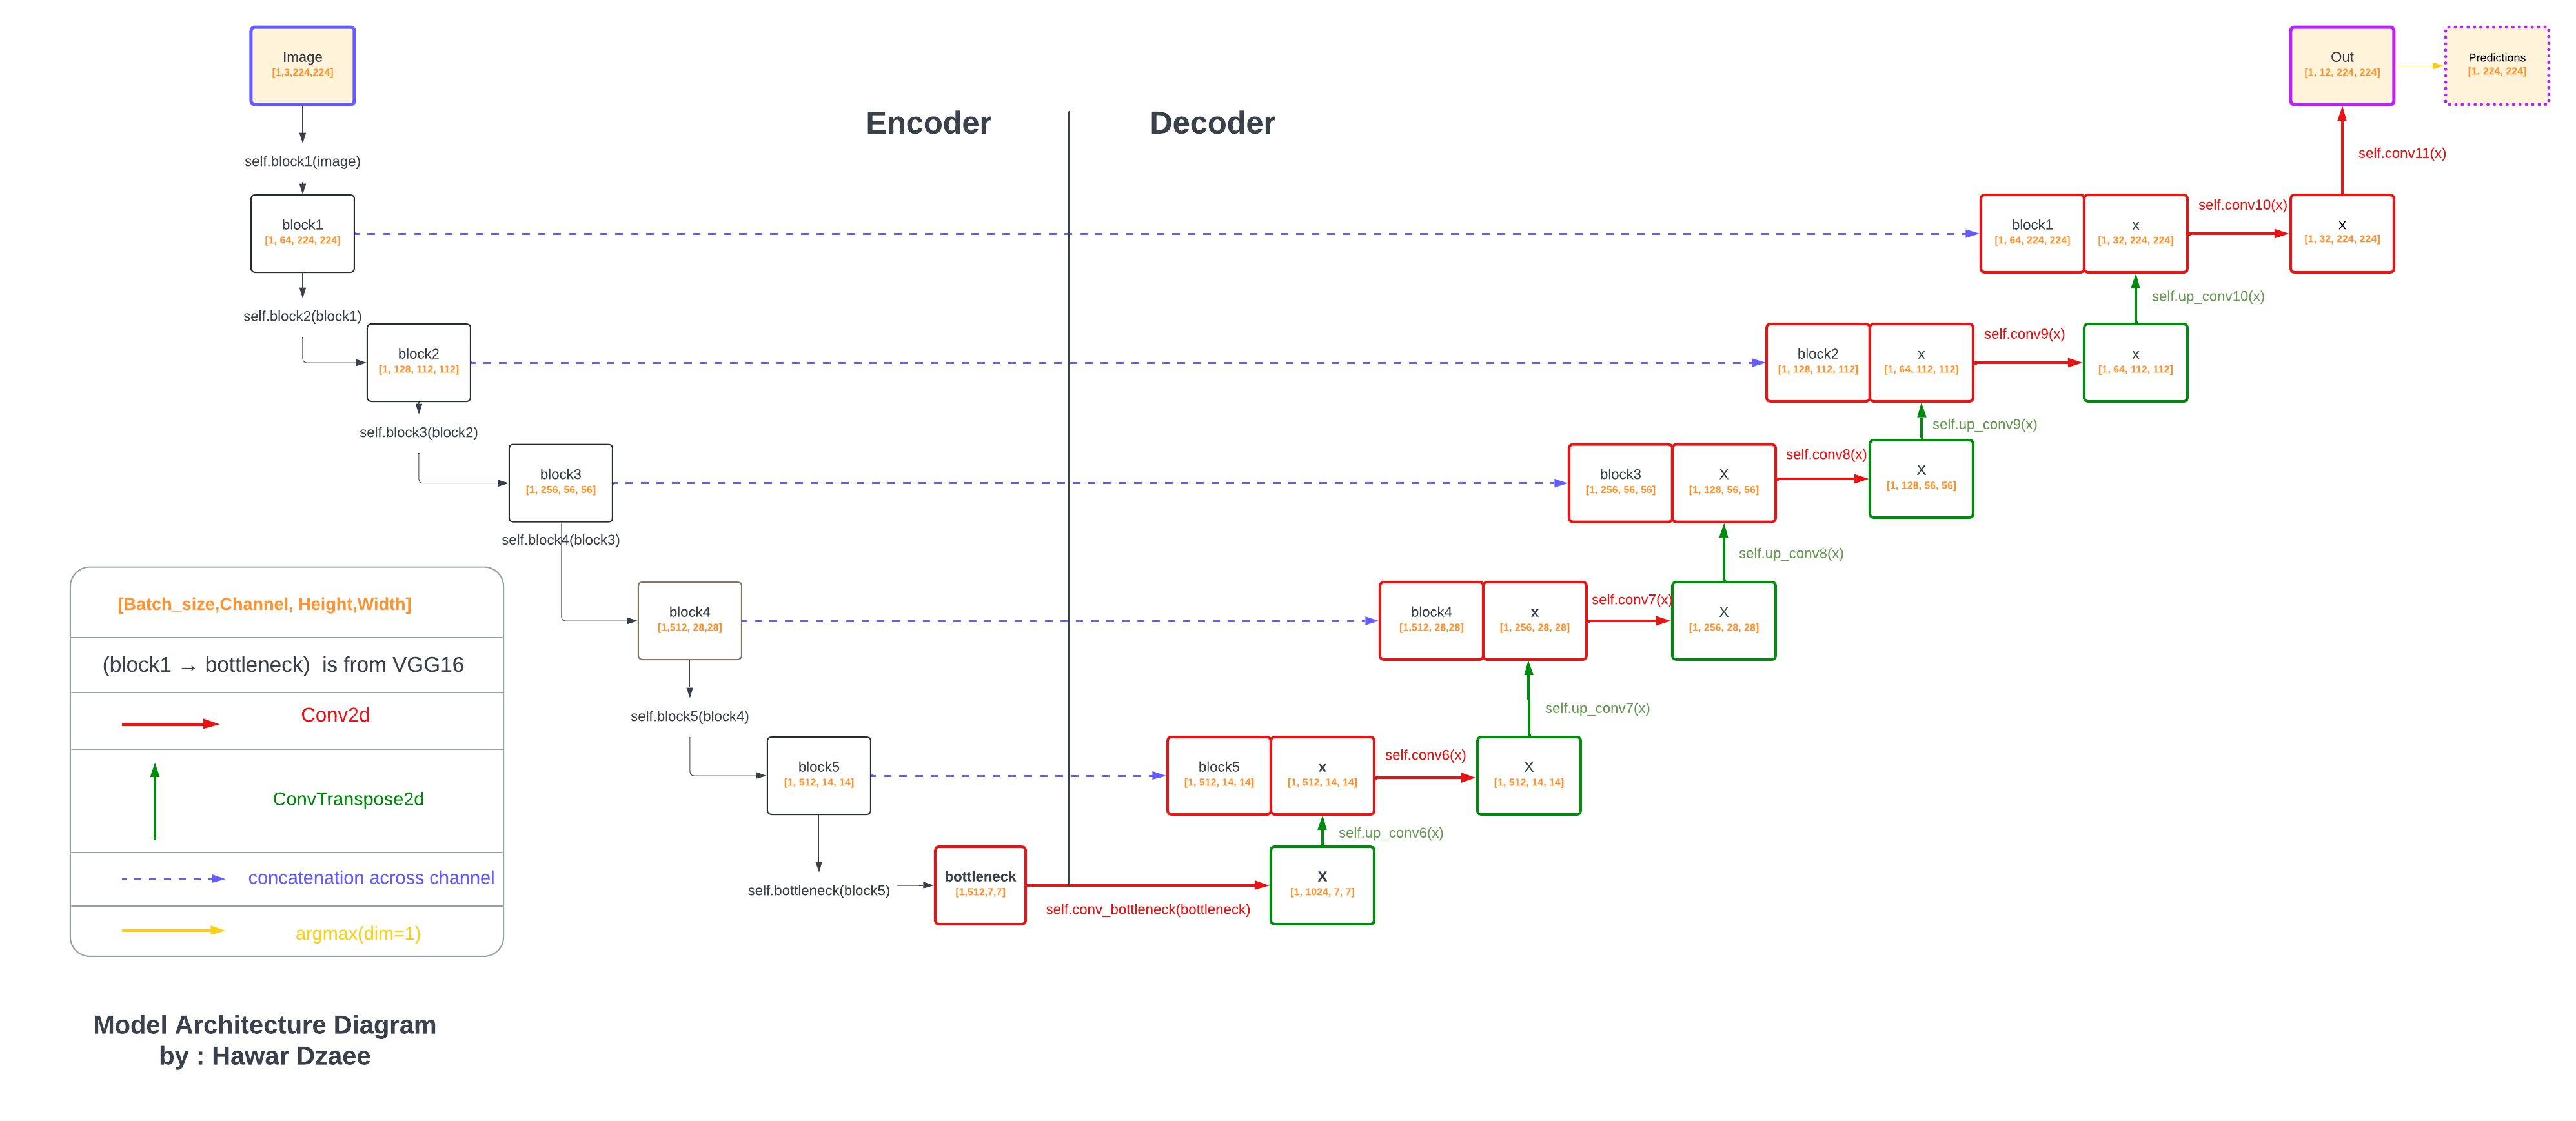

In [ ]:
model = UNet().to(device)

In [ ]:
with torch.no_grad():
  dummy_input = torch.zeros(1,3,224,224).to(device)
  print(model(dummy_input).shape)       # checking if the model is accepting our input shape and giving the desired output shape.

torch.Size([1, 12, 224, 224])


In [ ]:
ce = nn.CrossEntropyLoss()
optimizer = HyperParameters['optimization'](model.parameters(),lr= HyperParameters['lr'])

# Neptune Logger

In [ ]:
from neptune_pytorch import NeptuneLogger

npt_logger = NeptuneLogger(
    run,
    model= model,
    log_model_diagram=True,
    log_gradients=False,
    log_parameters=False,
    log_freq=1,
)

In [ ]:
from neptune.utils import stringify_unsupported

# (Neptune) The base_namespace attribute of the logger can be used to log metadata consistently
# under the 'base_namespace' namespace.
run[npt_logger.base_namespace]["HyperParams"] = stringify_unsupported(HyperParameters)

# Training Loop

In [ ]:
n_epochs = HyperParameters['epochs']

TRAINING_LOSS, TRAINING_ACC = [],[]
VAL_LOSS , VAL_ACC = [],[]

for epoch in range(1,n_epochs+1):
  print(f'Epoch : {epoch:02}',end=' | ')
  training_loss , training_acc = [],[]
  val_loss   , val_acc   = [],[]

  for ims,masks in train_dl:
    model.train()
    # moving input and output(ground truth) to(device)
    ims = ims.to(device)
    masks = masks.to(device)

    _masks = model(ims)   # forward pass

    loss = ce(_masks,masks)   # calculate the loss
    acc = (torch.argmax(_masks,dim=1) == masks).float().mean()  # calculate accuracy
    training_loss.append(loss.item())
    training_acc.append(acc.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  loss_per_epoch = torch.tensor(training_loss,dtype=torch.float).mean()
  TRAINING_LOSS.append(loss_per_epoch.item())
  acc_per_epoch = torch.tensor(training_acc,dtype=torch.float).mean()
  TRAINING_ACC.append(acc_per_epoch.item())

  print(f'Training Loss : {loss_per_epoch:.3f},  Training Accuracy : {acc_per_epoch:.3f}',end='  |  ')
  run[npt_logger.base_namespace]['Loss/training loss'].append(loss_per_epoch.item())         # neptune [logging training loss]
  run[npt_logger.base_namespace]['Accuracy/training Accuracy'].append(acc_per_epoch.item())  # neptune [logging training accuracy]


  with torch.no_grad():
    for ims,masks in val_dl:
      model.eval()
      ims = ims.to(device)
      masks = masks.to(device)
      _masks = model(ims)
      loss = ce(_masks,masks)

      acc = (torch.argmax(_masks,dim=1)==masks).float().mean()
      val_loss.append(loss.item())
      val_acc.append(acc.item())

    loss_per_epoch = torch.tensor(val_loss,dtype=torch.float).mean()
    VAL_LOSS.append(loss_per_epoch.item())
    acc_per_epoch = torch.tensor(val_acc,dtype=torch.float).mean()
    VAL_ACC.append(acc_per_epoch.item())

    print(f'Validation Loss : {loss_per_epoch:.3f}, Validation Accuracy : {acc_per_epoch:.3f}')
    run[npt_logger.base_namespace]['Loss/validation loss'].append(loss_per_epoch.item())        # neptune [logging validation loss]
    run[npt_logger.base_namespace]['Accuracy/validation Accuracy'].append(acc_per_epoch.item()) # neptune [logging validation accuracy]


    print('=='*60)




Epoch : 01 | Training Loss : 1.217,  Training Accuracy : 0.735  |  Validation Loss : 2.178, Validation Accuracy : 0.469
Epoch : 02 | Training Loss : 0.745,  Training Accuracy : 0.812  |  Validation Loss : 0.802, Validation Accuracy : 0.780
Epoch : 03 | Training Loss : 0.595,  Training Accuracy : 0.844  |  Validation Loss : 0.674, Validation Accuracy : 0.817
Epoch : 04 | Training Loss : 0.536,  Training Accuracy : 0.856  |  Validation Loss : 0.547, Validation Accuracy : 0.851
Epoch : 05 | Training Loss : 0.491,  Training Accuracy : 0.867  |  Validation Loss : 0.536, Validation Accuracy : 0.855
Epoch : 06 | Training Loss : 0.472,  Training Accuracy : 0.870  |  Validation Loss : 0.549, Validation Accuracy : 0.850
Epoch : 07 | Training Loss : 0.446,  Training Accuracy : 0.874  |  Validation Loss : 0.504, Validation Accuracy : 0.859
Epoch : 08 | Training Loss : 0.402,  Training Accuracy : 0.886  |  Validation Loss : 0.442, Validation Accuracy : 0.873
Epoch : 09 | Training Loss : 0.390,  Tra

# Plotting training/ validation Loss

You might not need to plot learning curves manually, as we are using the model experimentation tool (`neptune.ai`), which will automatically generate the plots.

In [ ]:
training_curve = go.Scatter(
  x = torch.arange(1,HyperParameters['epochs'] +1),
  y = TRAINING_LOSS,
  mode = 'lines',
  line = dict(color='red'),
  name = 'training loss'
)

valid_curve = go.Scatter(
  x = torch.arange(1,HyperParameters['epochs'] +1),
  y = VAL_LOSS,
  mode = 'lines',
  line = dict(color='yellow'),
  name = 'validation curve'
)

figure = go.Figure(data=[training_curve,valid_curve])
figure.show()

# Plotting training/ validation Accuracy

In [ ]:
training_curve = go.Scatter(
  x = torch.arange(1,HyperParameters['epochs'] +1),
  y = TRAINING_ACC,
  mode = 'lines',
  line = dict(color='red'),
  name = 'training Accuracy'
)

valid_curve = go.Scatter(
  x = torch.arange(1,HyperParameters['epochs'] +1),
  y = VAL_ACC,
  mode = 'lines',
  line = dict(color='yellow'),
  name = 'validation Accuracy'
)

figure = go.Figure(data=[training_curve,valid_curve])
figure.show()

# Predictions

torch.Size([12, 224, 224])


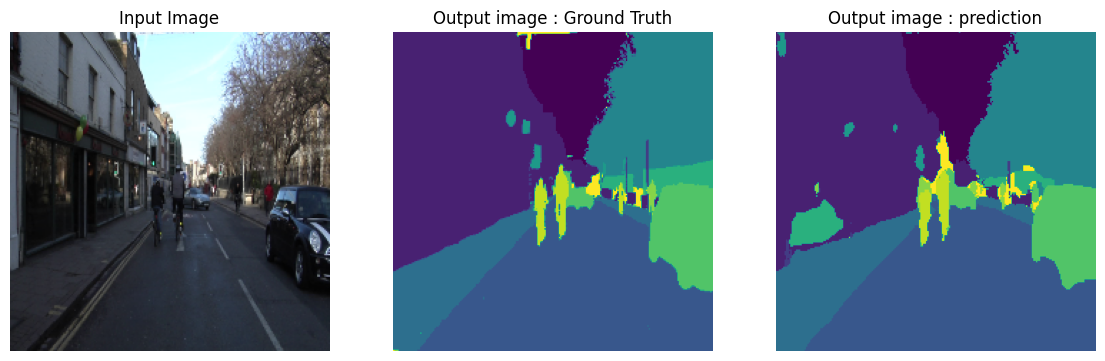

In [ ]:
test_ds_no_transformation = SegData(split='test',transforms=None)

model = model.to('cpu')
with torch.no_grad():
  model.eval()

  random_index = random.choice(range(0,len(test_ds_no_transformation)))

  # the instance without transformation
  ims_without_transformation,_ = test_ds_no_transformation[random_index]
  ims,mask = test_ds[random_index]

  prediction = model(ims.unsqueeze(0)).squeeze(0)
  print(prediction.shape)
  prediction = torch.argmax(prediction,dim=0)

  fig,ax = plt.subplots(1,3,figsize=(14,14))

  ax[0].imshow(ims_without_transformation)
  ax[0].axis('off')
  ax[0].set_title('Input Image')

  ax[1].imshow(mask)
  ax[1].axis('off')
  ax[1].set_title('Output image : Ground Truth')


  ax[2].imshow(prediction)
  ax[2].axis('off')
  ax[2].set_title('Output image : prediction')

In [ ]:
run.stop()